## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [55]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [56]:
# Opening JSON file
f = open('complaints-2021-05-14_08_16.json')  # Provide the path to your data file here

# returns JSON object as a dictionary
data = json.load(f)

# Normalize the JSON data into a pandas DataFrame
df = pd.json_normalize(data)

# Close the file after loading the data
f.close()

## Data preparation

In [57]:
# Inspect the dataframe to understand the given data.
df.info()  # Gives an overview of the columns and data types
df.head()  # Displays the first few rows of the dataframe



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [58]:
#print the column names
print(df.columns)


Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [59]:
# Assigning new column names for easier access and readability
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 
              'issue', 'date_received', 'state', 'consumer_disputed', 'product', 
              'company_response', 'company', 'submitted_via', 'date_sent_to_company', 
              'company_public_response', 'sub_product', 'timely_response', 
              'complaint_text', 'sub_issue', 'consumer_consent']


In [60]:
# Replace blanks in the complaint_text column with NaN
df['complaint_text'].replace('', np.nan, inplace=True)


In [61]:
# Remove all rows where complaint_text column is NaN
df.dropna(subset=['complaint_text'], inplace=True)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [62]:
# Function to clean text
def clean_text(text):
    # Make the text lowercase
    text = text.lower()
    
    # Remove text inside square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

# Apply the function to the 'complaint_text' column
df['cleaned_complaint_text'] = df['complaint_text'].apply(clean_text)


In [63]:
# Function to lemmatize the texts in batches
def lemmatize_text_batch(texts):
    docs = nlp.pipe(texts, batch_size=1000)  # Adjust batch size as needed
    return [' '.join([token.lemma_ for token in doc]) for doc in docs]

# Apply the function to the entire column
df['lemmatized_complaint_text'] = lemmatize_text_batch(df['cleaned_complaint_text'])


In [64]:
# Create a DataFrame that contains only the raw complaint and the lemmatized complaint
df_clean = df[['complaint_text', 'lemmatized_complaint_text']]
df_clean.columns = ['raw_complaint', 'lemmatized_complaint']


In [65]:
df_clean

,raw_complaint,lemmatized_complaint
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...
...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve hav...


In [66]:
# Function to extract POS tags and remove non-NN (noun) words
def pos_tag(text):
    doc = nlp(text)
    # Only keep words that are tagged as nouns (NN)
    return ' '.join([token.text for token in doc if token.pos_ == "NOUN"])

# Apply the function to filter out non-nouns from the lemmatized text
df_clean['complaint_POS_removed'] = df_clean['lemmatized_complaint'].apply(pos_tag)


C:\Users\sriab\AppData\Local\Temp\ipykernel_16908\1676421977.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
# The cleaned dataframe should now contain:
# - raw_complaint: the original complaint text
# - lemmatized_complaint: the lemmatized text
# - complaint_POS_removed: the text with only nouns
df_clean.head()


,raw_complaint,lemmatized_complaint,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,chase card report application identity consent...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




C:\Users\sriab\AppData\Local\Temp\ipykernel_16908\1923727857.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sriab\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



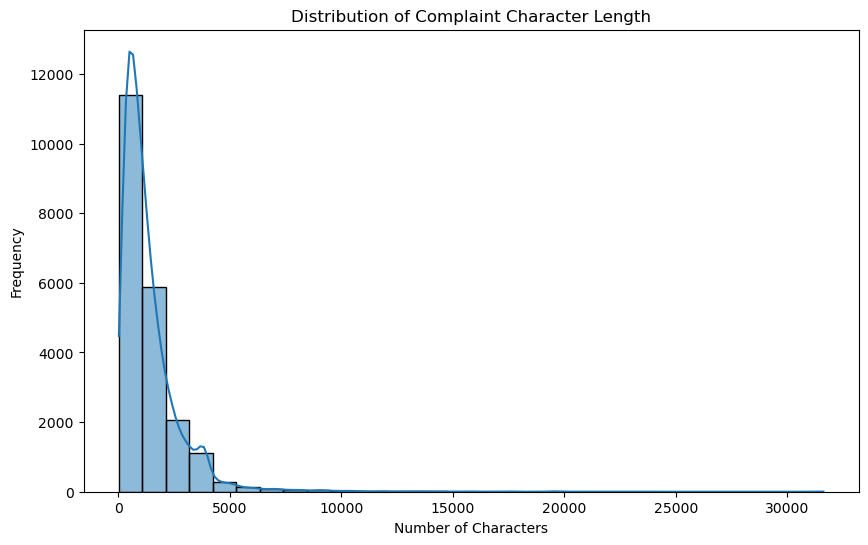

In [68]:
# Write your code here to visualise the data according to the 'Complaint' character length
# Add a column to calculate the length of each complaint
df_clean['complaint_length'] = df_clean['raw_complaint'].apply(lambda x: len(x))

# Plot the distribution of complaint lengths
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['complaint_length'], kde=True, bins=30)
plt.title('Distribution of Complaint Character Length')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

In [69]:
!pip install wordcloud


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\sriab\AppData\Local\Temp\ipykernel_16908\1929723684.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



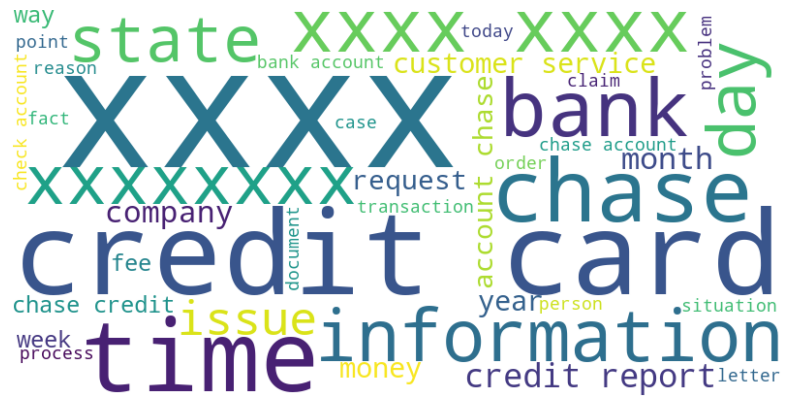

In [70]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
# Removing '-PRON-' from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '', regex=False)

# Import WordCloud
from wordcloud import WordCloud

# Join all the complaints into one large string for word cloud generation
all_complaints = ' '.join(df_clean['Complaint_clean'].values)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate(all_complaints)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [71]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
# Define the function to find the top unigrams
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 30 unigrams
top_30_unigrams = get_top_ngrams(df_clean['Complaint_clean'], n=30, ngram_range=(1, 1))

# Print the top 30 unigrams
print("Top 30 Unigrams:")
for unigram in top_30_unigrams:
    print(unigram)

Top 30 Unigrams:
('chase', 52740)
('xxxx', 48288)
('account', 46731)
('credit', 33470)
('card', 30216)
('bank', 21612)
('payment', 21158)
('time', 16008)
('charge', 14152)
('xxxxxxxx', 13581)
('day', 12971)
('check', 12099)
('money', 11953)
('loan', 10899)
('information', 9644)
('letter', 9598)
('fee', 8890)
('report', 8855)
('number', 8614)
('transaction', 8564)
('month', 8461)
('amount', 8422)
('call', 8365)
('year', 8289)
('customer', 8137)
('mortgage', 8072)
('balance', 7759)
('service', 7698)
('phone', 7570)
('company', 7534)


In [72]:
#Print the top 10 words in the unigram frequency
print("\nTop 10 Unigrams:")
for unigram in top_30_unigrams[:10]:
    print(unigram)


Top 10 Unigrams:
('chase', 52740)
('xxxx', 48288)
('account', 46731)
('credit', 33470)
('card', 30216)
('bank', 21612)
('payment', 21158)
('time', 16008)
('charge', 14152)
('xxxxxxxx', 13581)


In [73]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_bigrams = get_top_ngrams(df_clean['Complaint_clean'], n=30, ngram_range=(2, 2))

# Print the top 30 bigrams
print("\nTop 30 Bigrams:")
for bigram in top_30_bigrams:
    print(bigram)


Top 30 Bigrams:
('credit card', 12844)
('xxxx xxxx', 5047)
('credit report', 3927)
('customer service', 3058)
('account chase', 2824)
('chase credit', 2794)
('chase account', 2541)
('bank account', 2404)
('check account', 2249)
('account account', 2129)
('chase bank', 2063)
('debit card', 1965)
('checking account', 1847)
('chase card', 1736)
('credit score', 1707)
('account xxxx', 1704)
('phone call', 1652)
('number xxxx', 1645)
('xxxx credit', 1637)
('xxxx chase', 1627)
('card account', 1613)
('card chase', 1490)
('xxxx account', 1433)
('account credit', 1393)
('chase xxxx', 1322)
('interest rate', 1288)
('money account', 1258)
('business day', 1253)
('account bank', 1253)
('phone number', 1241)


In [74]:
#Print the top 10 words in the bigram frequency
print("\nTop 10 Bigrams:")
for bigram in top_30_bigrams[:10]:
    print(bigram)


Top 10 Bigrams:
('credit card', 12844)
('xxxx xxxx', 5047)
('credit report', 3927)
('customer service', 3058)
('account chase', 2824)
('chase credit', 2794)
('chase account', 2541)
('bank account', 2404)
('check account', 2249)
('account account', 2129)


In [75]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_trigrams = get_top_ngrams(df_clean['Complaint_clean'], n=30, ngram_range=(3, 3))

# Print the top 30 trigrams
print("\nTop 30 Trigrams:")
for trigram in top_30_trigrams:
    print(trigram)


Top 30 Trigrams:
('chase credit card', 1884)
('credit card account', 1069)
('credit card company', 981)
('xxxx credit card', 796)
('xxxx xxxx xxxx', 787)
('credit card chase', 685)
('inquiry credit report', 488)
('credit card credit', 484)
('credit card xxxx', 400)
('account credit card', 398)
('chase customer service', 385)
('credit reporting agency', 382)
('charge credit card', 372)
('chase checking account', 371)
('card credit card', 362)
('credit report credit', 350)
('customer service representative', 339)
('credit reporting act', 338)
('credit card payment', 295)
('chase bank account', 279)
('credit card charge', 271)
('account number xxxx', 265)
('account credit report', 259)
('bank credit card', 258)
('chase card service', 255)
('account chase account', 255)
('chase auto finance', 253)
('victim identity theft', 251)
('credit card balance', 250)
('credit card card', 239)


In [76]:
#Print the top 10 words in the trigram frequency
print("\nTop 10 Trigrams:")
for trigram in top_30_trigrams[:10]:
    print(trigram)


Top 10 Trigrams:
('chase credit card', 1884)
('credit card account', 1069)
('credit card company', 981)
('xxxx credit card', 796)
('xxxx xxxx xxxx', 787)
('credit card chase', 685)
('inquiry credit report', 488)
('credit card credit', 484)
('credit card xxxx', 400)
('account credit card', 398)


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [77]:
##df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')
# Remove the masked text 'xxxx' from the cleaned complaints
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx', '')


C:\Users\sriab\AppData\Local\Temp\ipykernel_16908\2472306733.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [78]:
#All masked texts has been removed
df_clean

,raw_complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,486,morning name stop bank service ask debt verifi...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,355,card agent anniversary date agent information...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,chase card report application identity consent...,224,chase card report application identity consent...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,1502,ticket offer ticket reward card information ...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,679,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,2114,credit card provider claim purchase protectio...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,2319,risk consumer chase bank app chase year banki...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,2171,credit yrs chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [79]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer with specified parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the 'Complaint_clean' column to create the TF-IDF feature matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])

# Display the shape of the TF-IDF matrix
print(f'TF-IDF matrix shape: {tfidf_matrix.shape}')


TF-IDF matrix shape: (21072, 6864)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [80]:
# Create the Document Term Matrix (DTM) by transforming the complaints column using the TfidfVectorizer
dtm = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])

# Convert the DTM to a DataFrame for easier interpretation (optional)
dtm_df = pd.DataFrame(dtm.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the shape of the DTM
print(f'Document-Term Matrix shape: {dtm.shape}')

Document-Term Matrix shape: (21072, 6864)


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [162]:
from sklearn.decomposition import NMF

# Set the number of clusters (topics) to 5
n_clusters = 5

# Initialize the NMF model
nmf_model = NMF(n_components=n_clusters, random_state=42)

# Fit the model and transform the document-term matrix (dtm) into NMF components
nmf_features = nmf_model.fit_transform(dtm)

# Display the shape of the resulting matrix
print("Shape of the NMF features matrix:", nmf_features.shape)

# Get the components (word clusters) from the NMF model
nmf_components = nmf_model.components_

# Display the top words for each topic
import numpy as np

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Get the feature names from the TfidfVectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Display the top 10 words for each topic
display_topics(nmf_model, tfidf_feature_names, 10)


Shape of the NMF features matrix: (21072, 5)
Topic 0:
account check bank money fund chase deposit branch day checking
Topic 1:
card credit chase balance account limit score year point month
Topic 2:
payment loan mortgage chase home month modification time year rate
Topic 3:
report inquiry credit company information reporting debt identity account theft
Topic 4:
charge dispute transaction chase fee merchant claim fraud purchase service


In [82]:
# Assign the topic number to each complaint based on the highest value in nmf_features
df_clean['topic'] = nmf_features.argmax(axis=1)

# Check the topic assignment for a few sample complaints
print(df_clean[['Complaint_clean', 'topic']].head(10))


                                      Complaint_clean  topic
1   morning name stop bank service ask debt verifi...      0
2    card agent anniversary date agent information...      1
10  chase card report application identity consent...      3
11    ticket offer ticket reward card information ...      3
14  son chase account fund chase bank account mone...      0
15                                            inquiry      3
17  notice account debit card branch customer serv...      0
20  summer month decline income employment month p...      2
21  payment retailer chase pay  chase website scam...      4
23      credit card datum credit report company issue      3


C:\Users\sriab\AppData\Local\Temp\ipykernel_16908\431331827.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [173]:
# Manually assign topic names based on the words in each cluster (after inspecting)
topic_names = {
    0: 'Bank Account Services',
    1: 'Credit Card/Prepaid Card',
    2: 'Mortgages/Loans',
    3: 'Theft/Dispute Reporting',
    4: 'Other Services'
}

# Map the topic numbers to topic names
df_clean['topic_name'] = df_clean['topic'].map(topic_names)

# Display the first few rows with the assigned topic names
df_clean[['Complaint_clean', 'topic', 'topic_name']].head(20)


,Complaint_clean,topic,topic_name
1,morning name stop bank service ask debt verifi...,0,Bank Account Services
24,mishandle account chase auto,0,Bank Account Services
17,notice account debit card branch customer serv...,0,Bank Account Services
14,son chase account fund chase bank account mone...,0,Bank Account Services
27,account bank code bonus term account deposit...,0,Bank Account Services
32,chase card decline catering order place brothe...,1,Credit Card/Prepaid Card
59,chase reward point month reward account bonus ...,1,Credit Card/Prepaid Card
52,roommate chase debit card driver license money...,1,Credit Card/Prepaid Card
2,card agent anniversary date agent information...,1,Credit Card/Prepaid Card
50,citizen scamme company time share company refu...,1,Credit Card/Prepaid Card


## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [174]:
#Load your nmf_model with the n_components i.e 5
from sklearn.decomposition import NMF

# Load your nmf_model with the number of components (topics)
num_topics = 5  # You can adjust this number for testing different values
random_state = 40

# Initialize NMF model
nmf_model = NMF(n_components=num_topics, random_state=random_state)


In [175]:
# Fit the model on the document-term matrix (dtm)
nmf_model.fit(dtm)

# Get the number of features (words) in the tf-idf matrix
num_features = len(tfidf_vectorizer.get_feature_names_out())
print(num_features)  # Print number of features to verify

6864


In [176]:
#Print the Top15 words for each of the topics

# Function to print the top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Get the feature names from the tf-idf vectorizer
tfidf_feature_names = tfidf.get_feature_names_out()

# Print the top 15 words for each topic
n_top_words = 15
print_top_words(nmf_model, tfidf_feature_names, n_top_words)

Topic 0:
account check bank money fund chase deposit branch day checking number business transfer transaction customer
Topic 1:
card credit chase balance account limit score year point month purchase offer application service time
Topic 2:
payment loan mortgage chase home month modification time year rate property balance statement date letter
Topic 3:
report inquiry credit company information reporting debt identity account theft score letter date file creditor
Topic 4:
charge dispute transaction chase fee merchant claim fraud purchase service email refund time company day


In [190]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
# Transform the document-term matrix using the NMF model
#topic_values = nmf_model.transform(dtm)

# Assign the topic with the highest score for each complaint
#df_clean['Topic'] = topic_values.argmax(axis=1)



In [191]:
# Group by topic and select the first 5 complaints for each topic
df_clean = df_clean.groupby('Topic').head(5)

# Sort the dataframe by topic for better readability
df_clean = df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [193]:
df_clean.head(10)

,raw_complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,Complaint_clean,topic,topic_name,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,486,morning name stop bank service ask debt verifi...,0,Bank Account Services,0
24,mishandling of this account by Chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account chase auto xxxx,51,mishandle account chase auto,0,Bank Account Services,0
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,2277,notice account debit card branch customer serv...,0,Bank Account Services,0
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...,0,Bank Account Services,0
27,I opened an account with chase bank on XXXX an...,I open an account with chase bank on xxxx and ...,account bank code bonus xxxxxxxx term account ...,413,account bank code bonus term account deposit...,0,Bank Account Services,0
32,My chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase card decline catering order place brothe...,1972,chase card decline catering order place brothe...,1,Credit Card/Prepaid Card,1
59,I currently have over XXXX Chase Ultimate Rewa...,I currently have over xxxx chase ultimate rewa...,chase reward point month reward account bonus ...,1897,chase reward point month reward account bonus ...,1,Credit Card/Prepaid Card,1
52,My roommate was stealing my Chase debit card a...,my roommate be steal my chase debit card and d...,roommate chase debit card driver license money...,843,roommate chase debit card driver license money...,1,Credit Card/Prepaid Card,1
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,355,card agent anniversary date agent information...,1,Credit Card/Prepaid Card,1
50,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,I be a senior citizen that have be scamme by s...,citizen scamme company time share company refu...,350,citizen scamme company time share company refu...,1,Credit Card/Prepaid Card,1


In [194]:
# Keep the columns "Complaint_clean" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['Complaint_clean', 'topic']]

In [195]:
training_data

,Complaint_clean,topic
1,morning name stop bank service ask debt verifi...,0
24,mishandle account chase auto,0
17,notice account debit card branch customer serv...,0
14,son chase account fund chase bank account mone...,0
27,account bank code bonus term account deposit...,0
32,chase card decline catering order place brothe...,1
59,chase reward point month reward account bonus ...,1
52,roommate chase debit card driver license money...,1
2,card agent anniversary date agent information...,1
50,citizen scamme company time share company refu...,1


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [196]:
from sklearn.feature_extraction.text import CountVectorizer

# Write your code to get the Vector count
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(training_data['Complaint_clean'])

In [197]:
from sklearn.feature_extraction.text import TfidfTransformer

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [198]:
from sklearn.model_selection import train_test_split

# Create train and test data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, training_data['topic'], test_size=0.2, random_state=42)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [199]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB()
}


# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print("=" * 50)

Model: Logistic Regression
Accuracy: 0.6
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       0.33      1.00      0.50         1

    accuracy                           0.60         5
   macro avg       0.47      0.60      0.50         5
weighted avg       0.47      0.60      0.50         5

Model: Decision Tree
Accuracy: 0.6
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         1
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1

    accuracy                           0.60         5
   macro avg       0.40      0.60      0.47         5
w

C:\Users\sriab\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sriab\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sriab\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\sriab\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\U

#### The best model we got is the "Naive Bayes". So let's use our best model and try to predict on th custom text. 

In [188]:
# Assuming you already have your models defined and trained
# Sample custom text for inference
custom_text = ["I want to keep my house for Mortgage"]

# Step 1: Preprocess the custom text
def preprocess_text(text):
    # Use the same vectorizer you used for training
    return vectorizer.transform(text)

# Preprocess the custom text
processed_text = preprocess_text(custom_text)

# Step 2: Make prediction

# Here model means the best model which is ""Naive Bayes""

# Make prediction with the best model
predicted_class = model.predict(processed_text)

# Step 3: Output the prediction
print(f"Predicted class for the custom text: {predicted_class[0]}")


Predicted class for the custom text: 2


As we can see the Model has corrrectly predicted as 2 which means Mortgages/Loans.

    0: 'Bank Account Services',
    1: 'Credit Card/Prepaid Card',
    2: 'Mortgages/Loans',
    3: 'Theft/Dispute Reporting',
    4: 'Other Services'